# IMPORTS AND SETUP

In [1]:
%matplotlib inline
import pandas as pd
import random
import tkinter as tk
from collections import OrderedDict
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn as sk
from enum import Enum
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
import time
import math
from matplotlib import colors

In [2]:
# random_seed = int(time.time()//1)
# print(random_seed)
random_seed = 222
# 87348926
# 22732713
# 8 1.38
# 4 1.27
# 1 .89
# 89 1.14
#40
# red=0, green=1, blue=2, cyan=3, magenta=4, yellow=5
cmap = colors.ListedColormap(['r','g','b','c','m', 'y'])

In [3]:
unclean_detailed_info = pd.read_csv('..\Resources\BoardGames\games_detailed_info.csv')

In [4]:
clean_detailed_info = unclean_detailed_info.drop(['Unnamed: 0', 'type', 'id', 'thumbnail', 'image', 'primary',
       'alternate', 'description', 'yearpublished', 'boardgameexpansion', 'boardgameimplementation',
       'boardgamedesigner', 'boardgameartist', 'boardgamepublisher', 'boardgameintegration', 'boardgamecompilation', 'boardgamecategory',
       'boardgamemechanic', 'boardgamefamily', 'RPG Item Rank', 'Accessory Rank', 'Video Game Rank', 'Amiga Rank',
       'Commodore 64 Rank', 'Arcade Rank', 'Atari ST Rank'], axis=1)

# FUNCTIONS

In [5]:
def sum_of_array(an_array):
    sum = 0 
    for i in an_array:
        sum += i
    return sum

In [6]:
def draw_vector(v0, v1, ax=None):
    ax = ax or plt.gca()
    arrowprops=dict(arrowstyle='->',
                    linewidth=2,
                    shrinkA=0, shrinkB=0)
    ax.annotate('', v1, v0, arrowprops=arrowprops)

In [7]:
language_value = {
    'NO' : 1,
    'SOME' : 2,
    'MODERATE' : 3,
    'EXTENSIVE' : 4,
    'UNPLAYABLE' : 5
}

def normalize_language_dependence(game):
    sum_of_weighted_language = 0
    total_num_votes = 0
    for level in game:
        value_key = level['@value'].split(' ')[0].upper()
        language_multiplier = language_value[value_key]
        votes = int(level['@numvotes'])
        total_num_votes += votes
        sum_of_weighted_language += language_multiplier * votes
    return (sum_of_weighted_language / total_num_votes) if total_num_votes > 0 else 0

In [8]:
def add_brackets_and_eval(string_item):
    string_item = str(string_item)
    if string_item[0] != '[':
        string_item = '[' + str(string_item)
    if string_item[-1] != ']':
        string_item = str(string_item) + ']'
    return eval(string_item)

In [9]:
def is_empty_playercount(game):
    for playercount in game:
        if 'result' in playercount:
            return True
        else: 
            return False

In [10]:
def calculate_age_from_ordered_dict(game):
    weighted_age_sum = 0
    total_votes = 0
    for age in game:
        votes = age['@numvotes']
        if age['@value'].isnumeric():
            age_num = age['@value']
        else:
            age_num = 25
        weighted_age_sum += int(age_num) * int(votes) 
        total_votes += int(votes)
    if total_votes:
        return weighted_age_sum/total_votes
    else:
        return 0

In [11]:
result_value = {
    'BEST' : 3,
    'RECOMMENDED' : 2,
    'NOTRECOMMENDED' : 1   
}

def calculate_players_from_ordered_dict(game):
    playercount_normalized_results = {}
    for playercount in game:
        if not 'result' in playercount:
            return 0
        total_votes = 0
        result_total_result = 0
        result_normalized_result = 0
        for result in playercount['result']:
            current_player_count = result['@value']
            multiplier = result_value[result['@value'].upper().replace(' ', '')]
            total_votes += int(result['@numvotes'])
            result_total_result += int(result['@numvotes']) * multiplier
        if(total_votes):
            result_normalized_result = result_total_result / total_votes
        else:
            result_normalized_result = 0
            result_normalized_result = 0
        playercount_normalized_results[playercount['@numplayers']]=result_normalized_result
    sum_of_weighted_players = 0
    sum_of_keys = 0
    num_of_keys = 0
    for key in playercount_normalized_results.keys():
        if not key.isnumeric():
            num = int(key[:-1]) + 1
        else:
            num = int(key)
        sum_of_weighted_players += num * (playercount_normalized_results[key]/3)
        sum_of_keys += num
        num_of_keys += 1
    return (sum_of_weighted_players)/(sum_of_keys/num_of_keys)


# DATA CLEANING

In [12]:
clean_detailed_info = clean_detailed_info.fillna(0)

In [13]:
clean_detailed_info['suggested_num_players'] = clean_detailed_info['suggested_num_players'].apply(add_brackets_and_eval)
clean_detailed_info['suggested_num_players'] = clean_detailed_info['suggested_num_players'].apply(calculate_players_from_ordered_dict)

In [14]:
clean_detailed_info = clean_detailed_info[clean_detailed_info['suggested_playerage'] != 0]
clean_detailed_info['suggested_playerage'] = clean_detailed_info['suggested_playerage'].apply(add_brackets_and_eval)
clean_detailed_info['suggested_playerage'] = clean_detailed_info['suggested_playerage'].apply(calculate_age_from_ordered_dict)

In [15]:
clean_detailed_info = clean_detailed_info[clean_detailed_info['suggested_language_dependence'] != 0]
clean_detailed_info['suggested_language_dependence'] = clean_detailed_info['suggested_language_dependence'].apply(add_brackets_and_eval)
clean_detailed_info['suggested_language_dependence'] = clean_detailed_info['suggested_language_dependence'].apply(normalize_language_dependence)

In [16]:
clean_detailed_info = clean_detailed_info[clean_detailed_info['suggested_num_players'] > 0]
clean_detailed_info = clean_detailed_info[clean_detailed_info['suggested_playerage'] > 0]
clean_detailed_info = clean_detailed_info[clean_detailed_info['suggested_language_dependence'] > 0]

# PRINTOUTS

In [17]:
print(unclean_detailed_info.columns)
print(unclean_detailed_info)

Index(['Unnamed: 0', 'type', 'id', 'thumbnail', 'image', 'primary',
       'alternate', 'description', 'yearpublished', 'minplayers', 'maxplayers',
       'suggested_num_players', 'suggested_playerage',
       'suggested_language_dependence', 'playingtime', 'minplaytime',
       'maxplaytime', 'minage', 'boardgamecategory', 'boardgamemechanic',
       'boardgamefamily', 'boardgameexpansion', 'boardgameimplementation',
       'boardgamedesigner', 'boardgameartist', 'boardgamepublisher',
       'usersrated', 'average', 'bayesaverage', 'Board Game Rank',
       'Strategy Game Rank', 'Family Game Rank', 'stddev', 'median', 'owned',
       'trading', 'wanting', 'wishing', 'numcomments', 'numweights',
       'averageweight', 'boardgameintegration', 'boardgamecompilation',
       'Party Game Rank', 'Abstract Game Rank', 'Thematic Rank',
       'War Game Rank', 'Customizable Rank', 'Children's Game Rank',
       'RPG Item Rank', 'Accessory Rank', 'Video Game Rank', 'Amiga Rank',
       'Commod

In [18]:
print(clean_detailed_info.columns)
print(clean_detailed_info)

Index(['minplayers', 'maxplayers', 'suggested_num_players',
       'suggested_playerage', 'suggested_language_dependence', 'playingtime',
       'minplaytime', 'maxplaytime', 'minage', 'usersrated', 'average',
       'bayesaverage', 'Board Game Rank', 'Strategy Game Rank',
       'Family Game Rank', 'stddev', 'median', 'owned', 'trading', 'wanting',
       'wishing', 'numcomments', 'numweights', 'averageweight',
       'Party Game Rank', 'Abstract Game Rank', 'Thematic Rank',
       'War Game Rank', 'Customizable Rank', 'Children's Game Rank'],
      dtype='object')
       minplayers  maxplayers  suggested_num_players  suggested_playerage  \
0               2           4               3.294766             9.734205   
1               2           5               3.650544             7.615527   
2               3           4               3.075150             8.862408   
3               2           7               5.159062            10.004464   
4               2           4             

In [19]:
clean_detailed_info.shape[0]

12091

In [20]:
clean_detailed_info

,minplayers,maxplayers,suggested_num_players,suggested_playerage,suggested_language_dependence,playingtime,minplaytime,maxplaytime,minage,usersrated,...,wishing,numcomments,numweights,averageweight,Party Game Rank,Abstract Game Rank,Thematic Rank,War Game Rank,Customizable Rank,Children's Game Rank
0,2,4,3.294766,9.734205,2.130573,45,45,45,8,96241,...,8571,15778,5232,2.4148,0.0,0.0,0.0,0.0,0.0,0.0
1,2,5,3.650544,7.615527,1.028698,45,30,45,7,96228,...,6286,17720,7304,1.9158,0.0,0.0,0.0,0.0,0.0,0.0
2,3,4,3.075150,8.862408,2.034268,120,60,120,10,96213,...,5310,17859,7187,2.3264,0.0,0.0,0.0,0.0,0.0,0.0
3,2,7,5.159062,10.004464,1.251295,30,30,30,10,79873,...,10875,13304,4423,2.3321,0.0,0.0,0.0,0.0,0.0,0.0
4,2,4,3.181440,9.691038,3.145585,30,30,30,13,74959,...,7607,13008,4850,2.3586,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19222,2,2,2.333333,16.000000,3.500000,0,0,0,12,30,...,30,19,9,2.4444,0.0,0.0,0.0,2373.0,0.0,0.0
19225,2,4,3.000000,8.000000,1.000000,0,0,0,7,30,...,4,4,1,1.0000,0.0,0.0,0.0,0.0,0.0,0.0
19226,2,5,3.809524,8.000000,2.000000,30,15,30,10,30,...,1,13,2,2.0000,0.0,0.0,0.0,0.0,0.0,0.0
19227,3,8,3.133333,6.000000,1.000000,20,20,20,8,30,...,6,10,1,1.0000,0.0,0.0,0.0,0.0,0.0,0.0


# APPLICATION

In [21]:
scaler = StandardScaler().fit(clean_detailed_info)
scaled_set = scaler.transform(clean_detailed_info)
pca_set = PCA(n_components=2, random_state=random_seed)
principalComponentsGames = pca_set.fit_transform(scaled_set)
principalComponentsGamesDF = pd.DataFrame(data=principalComponentsGames, columns = ['PC1', 'PC2'])
train_set, test_set = train_test_split(principalComponentsGamesDF, test_size=0.2, random_state=random_seed, shuffle=True)


In [22]:
kmeans = KMeans(n_clusters=6, random_state=random_seed)
kmeans.fit(train_set)
y_kmeans = kmeans.predict(train_set)

In [23]:
y_testkmeans = kmeans.predict(test_set)

In [24]:
reg = LinearRegression().fit(train_set, y_kmeans)

In [25]:
#putting the cluster number in the unclean data set to retrieve results from later
all_games_kmeans = kmeans.predict(principalComponentsGamesDF)
clean_detailed_info['cluster'] = all_games_kmeans.tolist()
unclean_detailed_info['cluster'] = clean_detailed_info['cluster']

# TESTING

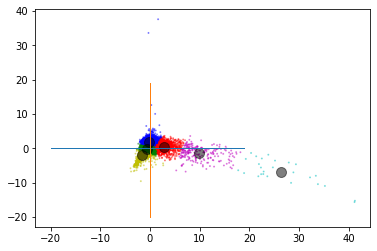

In [26]:
plt.scatter(train_set.iloc[:, 0], train_set.iloc[:, 1], c=y_kmeans, s=1, alpha=.4, cmap=cmap)

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=100, alpha=0.5);
plt.plot(range(-20,20), [0]*40, '-', linewidth=1)
plt.plot( [0]*40, range(-20,20), '-', linewidth=1)

In [27]:
print(reg.score(train_set, y_kmeans))
print(reg.predict(test_set))
print(y_testkmeans)

0.2673639033658445
[2.82120997 0.75051653 2.74872178 ... 1.00478064 1.62606474 1.00500557]
[5 0 1 ... 2 2 0]


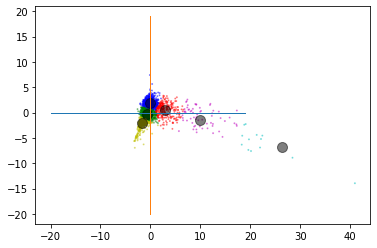

In [28]:
plt.scatter(test_set.iloc[:, 0], test_set.iloc[:, 1], c=y_testkmeans, s=1, alpha=.4, cmap=cmap)
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=100, alpha=0.5);
plt.plot(range(-20,20), [0]*40, '-', linewidth=1)
plt.plot( [0]*40, range(-20,20), '-', linewidth=1)

5
0
5.5763370554689065
-1.1769619241091327
1.3039212051034534


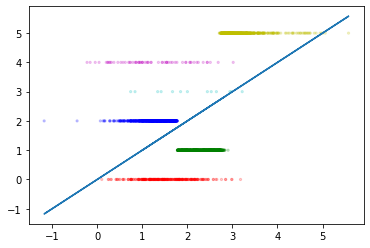

In [29]:
new_array = []
pred_vals = reg.predict(test_set)
for i in range(0,len(pred_vals)):
    new_array.append(abs(y_testkmeans[i] - pred_vals[i]))

print(max(y_testkmeans))
print(min(y_testkmeans))
print(max(pred_vals))
print(min(pred_vals))
print(sum_of_array(new_array)/len(new_array))

plt.scatter(pred_vals, y_testkmeans, c=y_testkmeans, s=5, alpha=.2, marker='o', cmap=cmap)
plt.plot(pred_vals, pred_vals, '-')

SUSPECT best option is to round down if <2.5 or >5 and up if >2.5 or <0 unless 

# STAGING

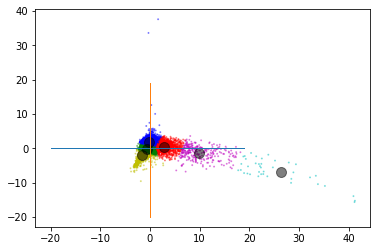

In [30]:
plt.scatter(principalComponentsGamesDF.iloc[:, 0], principalComponentsGamesDF.iloc[:, 1], c=all_games_kmeans, s=1, alpha=.4, cmap=cmap)
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=100, alpha=0.5);
plt.plot(range(-20,20), [0]*40, '-', linewidth=1)
plt.plot( [0]*40, range(-20,20), '-', linewidth=1)

In [80]:
def predict_game_cluster(game_id_list):
    number_of_features = len(clean_detailed_info.columns) - 1
    games = np.empty((0,number_of_features), float)
    for game_id in game_id_list:
        games = np.append(games, np.array([clean_detailed_info.iloc[game_id].drop('cluster')]), axis=0)
    average_of_games = np.average(games, axis=0)
    scaled_average = scaler.transform(average_of_games.reshape(1, -1))
    pca_average = pca_set.transform(scaled_average)
    predicted_cluster = reg.predict(pca_average)
    if predicted_cluster - math.floor(predicted_cluster) <= .5:
        predicted_cluster = math.floor(predicted_cluster)
    else:
        predicted_cluster = math.ceil(predicted_cluster)
    if predicted_cluster < 0:
        predicted_cluster = 0
    elif predicted_cluster > 5:
        predicted_cluster = 5

    
    return predicted_cluster

In [81]:
from collections import Counter
predictionlist = []
for i in range(1000):
    game_id_list = [random.randrange(10000)]*random.randrange(3,10)
    predictionlist.append(predict_game_cluster(game_id_list))
predicted_counts = Counter(predictionlist)
for i in range(6):
    print(str(i) + ': happens this often - ' + str(predicted_counts[i]/1000))

0: happens this often - 0.015
1: happens this often - 0.258
2: happens this often - 0.438
3: happens this often - 0.241
4: happens this often - 0.04
5: happens this often - 0.008


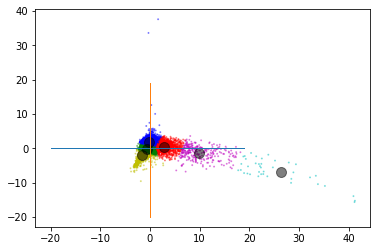

In [82]:
plt.scatter(principalComponentsGamesDF.iloc[:, 0], principalComponentsGamesDF.iloc[:, 1], c=all_games_kmeans, s=1, alpha=.4, cmap=cmap)
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=100, alpha=0.5);
plt.plot(range(-20,20), [0]*40, '-', linewidth=1)
plt.plot( [0]*40, range(-20,20), '-', linewidth=1)

print(scaled_set)
print(clean_detailed_info)

In [83]:
# for i in range(1000):
#     game_id_list = [random.randrange(10000)]*random.randrange(3,10)
#     predictionlist.append(predict_game_cluster(game_id_list))
all_counts = Counter(all_games_kmeans)
    
for i in range(6):
    print(str(i) + ': happens this often - ' + str(all_counts[i]/len(all_games_kmeans)))

0: happens this often - 0.10710445786121908
1: happens this often - 0.3711024729137375
2: happens this often - 0.2823587792572988
3: happens this often - 0.0032255396575965596
4: happens this often - 0.023653957489041436
5: happens this often - 0.21255479282110662


In [84]:
sum_average = {'predicted' : 0, 'actual': 0}
len_actual = len(all_games_kmeans)
len_predicted = len(predictionlist)
for i in range(6):
    prob_predicted = predicted_counts[i]/len_predicted
    prob_actual = all_counts[i]/len_actual
    print(str(i) + ': happens this often in all games - ' + str(prob_actual))
    print(str(i) + ': happens this often in predicted games- ' + str(prob_predicted))
    print('\nThe difference is ' + str(prob_actual - prob_predicted) + '\n\n\n')
    sum_average['predicted'] += prob_predicted
    sum_average['actual'] += prob_actual
print(sum_average)
    

0: happens this often in all games - 0.10710445786121908
0: happens this often in predicted games- 0.015

The difference is 0.09210445786121908



1: happens this often in all games - 0.3711024729137375
1: happens this often in predicted games- 0.258

The difference is 0.11310247291373748



2: happens this often in all games - 0.2823587792572988
2: happens this often in predicted games- 0.438

The difference is -0.1556412207427012



3: happens this often in all games - 0.0032255396575965596
3: happens this often in predicted games- 0.241

The difference is -0.23777446034240343



4: happens this often in all games - 0.023653957489041436
4: happens this often in predicted games- 0.04

The difference is -0.016346042510958565



5: happens this often in all games - 0.21255479282110662
5: happens this often in predicted games- 0.008

The difference is 0.2045547928211066



{'predicted': 1.0, 'actual': 1.0}
